<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** 

Оценим по запуску основного цикла обучения из задания 3. Видим, что скорость быстро увеличивается и выходит на примерно ровный уровень (продолжительное плато в районе 35-30-25 с) после размера батча 100. Возможно, связано с умением процессора распараллеливать процессы. Надо отметить, что accuracy при этом падает.

In [11]:
batch_sizes = [5, 30, 100, 256, 500, 1000, 1500, 2000]
fit_speed = []
accuracy = []

for cur_batch_size in batch_sizes:
    
    trainloader = DataLoader(trainset, batch_size=cur_batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=cur_batch_size, shuffle=False, num_workers=2)
    
    print(f"Batch size = {cur_batch_size}")
    fc_net = FCNet()
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
    res = %timeit -n 1 -r 1 -o fc_fit(n_epochs=10)
    fit_speed.append(res.average) 
    accuracy.append(get_accuracy(fc_net, testloader))

Batch size = 5
Epoch=1 loss=0.3289
Epoch=2 loss=0.1595
Epoch=3 loss=0.1143
Epoch=4 loss=0.0912
Epoch=5 loss=0.0722
Epoch=6 loss=0.0682
Epoch=7 loss=0.0618
Epoch=8 loss=0.0553
Epoch=9 loss=0.0504
Epoch=10 loss=0.0514
6min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Batch size = 30
Epoch=1 loss=0.3289
Epoch=2 loss=0.1595
Epoch=3 loss=0.1143
Epoch=4 loss=0.0912
Epoch=5 loss=0.0722
Epoch=6 loss=0.0682
Epoch=7 loss=0.0618
Epoch=8 loss=0.0553
Epoch=9 loss=0.0504
Epoch=10 loss=0.0514
1min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Batch size = 100
Epoch=1 loss=0.3289
Epoch=2 loss=0.1595
Epoch=3 loss=0.1143
Epoch=4 loss=0.0912
Epoch=5 loss=0.0722
Epoch=6 loss=0.0682
Epoch=7 loss=0.0618
Epoch=8 loss=0.0553
Epoch=9 loss=0.0504
Epoch=10 loss=0.0514
35.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Batch size = 256
Epoch=1 loss=0.3289
Epoch=2 loss=0.1595
Epoch=3 loss=0.1143
Epoch=4 loss=0.0912
Epoch=5 loss=0.0722
Epoch=6 loss=0.0682
Epoch=7 loss=0.06

In [12]:
speed_df = pd.DataFrame(list(zip(batch_sizes, fit_speed, accuracy)), columns =["Batch size", "Fit speed", "Accuracy"])
speed_df

Batch size   Fit speed  Accuracy
0           5  383.027414    0.9040
1          30   66.916669    0.9067
2         100   35.600915    0.9017
3         256   27.578361    0.9013
4         500   25.056980    0.9000
5        1000   23.042337    0.8789
6        1500   23.264972    0.8628
7        2000   22.600101    0.8592

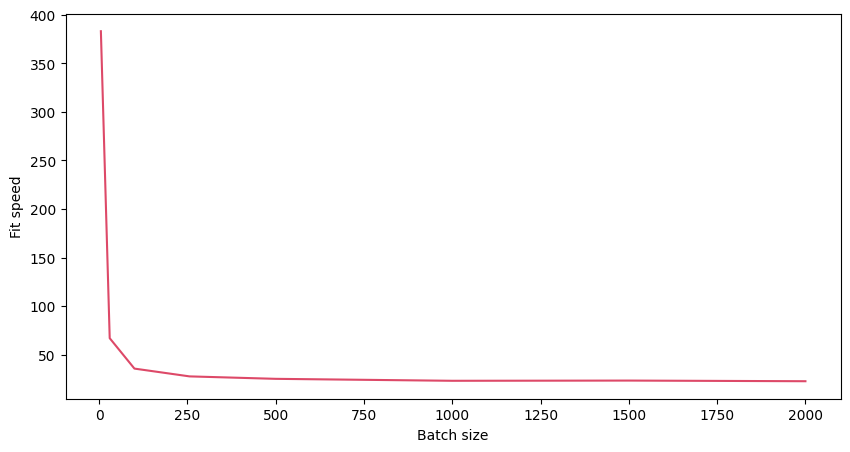

In [13]:
plt.figure(figsize=(10,5))
plt.plot(speed_df["Batch size"], speed_df["Fit speed"], c="#DD4968")
plt.xlabel("Batch size")
plt.ylabel("Fit speed")
plt.show()

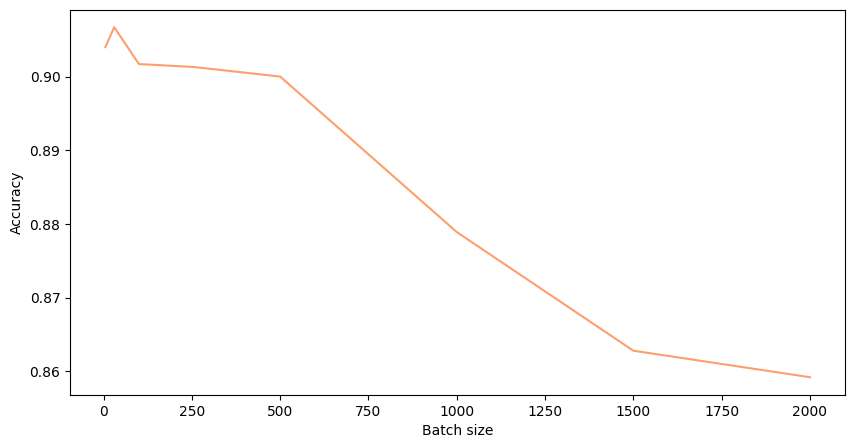

In [14]:
plt.figure(figsize=(10,5))
plt.plot(speed_df["Batch size"], speed_df["Accuracy"], c="#FD9F6C")
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.show()

Посмотрим на какую-нибудь картинку:

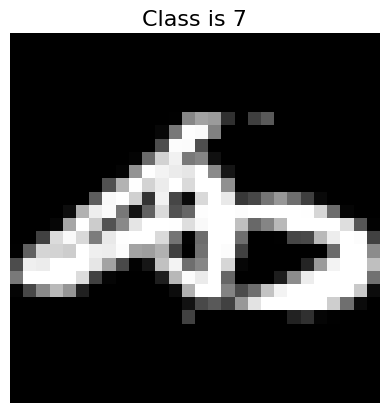

In [5]:
plt.imshow(trainset[1][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[1][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [6]:
examples = []
for i in range(10):
    for example in trainset:
        if example[1] == i:
            examples.append(example)
            break

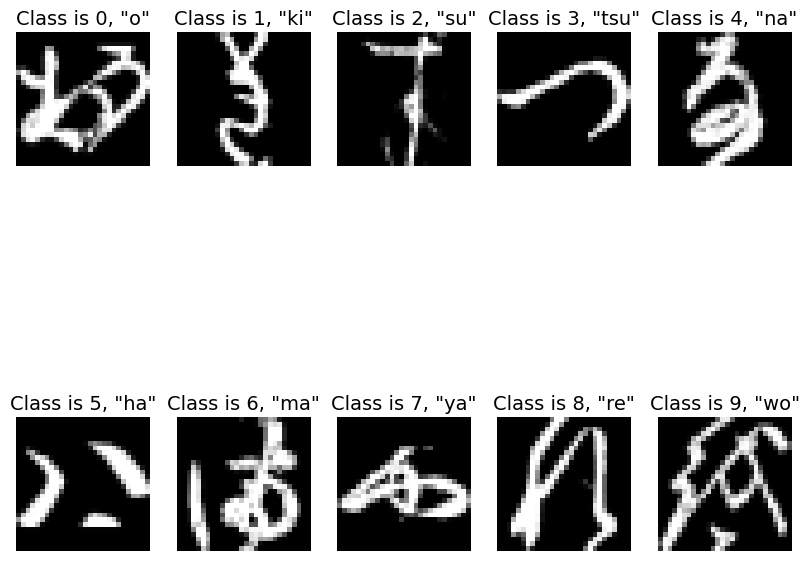

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
plt.subplots_adjust(hspace=0)
for example, ax, cl in zip(examples, axes.flatten(), trainset.classes):
    ax.imshow(example[0].view(28, 28).numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f'Class is {example[1]}, "{cl}"', fontsize=14);

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 слоя - 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

        #return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Сумма параметров в каждом из линейных слоев = input_features * output_features (веса) + output_features (смещения).  

Соответственно,    
слой 1: 784\*256 + 256     
слой 2: 256\*128 + 128    
слой 3: 128\*10 + 10    

784\*256 + 256 + 256\*128 + 128 + 128\*10 + 10 = 235146 параметров.

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [9]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [15]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [16]:
# возвращаем переменные после ответа на вопрос о влиянии на скорость обучения параметра batch_size

batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
loss_history = []
n_epochs = 10

## YOUR CODE HERE
def fc_fit(n_epochs=n_epochs):
    """
    n_epochs - количество эпох
    """
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # обнуляем градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

In [18]:
fc_fit(10)

Epoch=1 loss=0.6134
Epoch=2 loss=0.2777
Epoch=3 loss=0.1924
Epoch=4 loss=0.1428
Epoch=5 loss=0.1069
Epoch=6 loss=0.0836
Epoch=7 loss=0.0622
Epoch=8 loss=0.0460
Epoch=9 loss=0.0337
Epoch=10 loss=0.0262


In [19]:
acc = get_accuracy(fc_net, testloader)
print(f"Значение accuracy на тестовой выборке = {acc}")

Значение accuracy на тестовой выборке = 0.8967


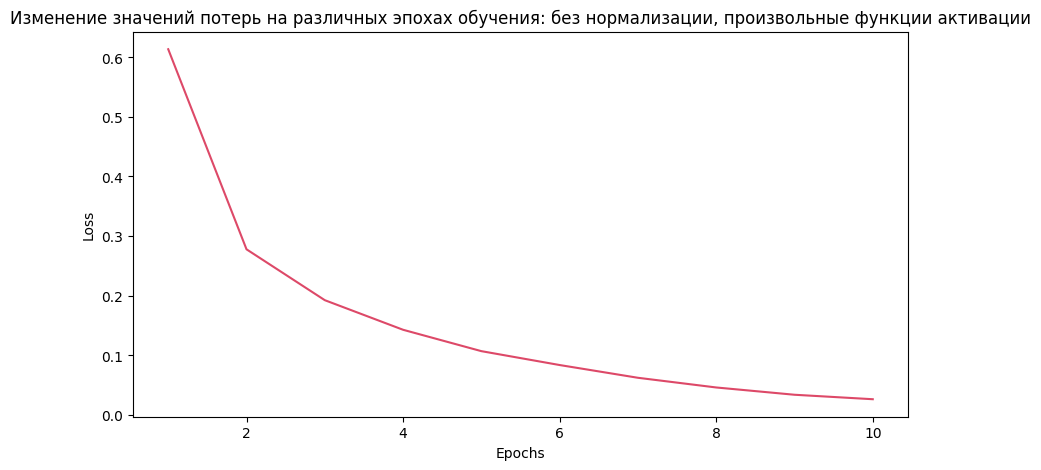

In [20]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#DD4968")
plt.title("Изменение значений потерь на различных эпохах обучения: без нормализации, произвольные функции активации")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [26]:
trainset_conv = trainset.data.to(torch.float)

std, mean = torch.std_mean(trainset_conv)
upper_bound = torch.max(trainset_conv)
std, mean = std / upper_bound, mean / upper_bound
print(f"Среднее и стандартное отклонение интенсивности пикселей для тренировочных данных: {mean, std}, соответственно.")

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Среднее и стандартное отклонение интенсивности пикселей для тренировочных данных: (tensor(0.1918), tensor(0.3483)), соответственно.


In [27]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [28]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE

fc_fit(n_epochs)

Epoch=1 loss=0.4493
Epoch=2 loss=0.1876
Epoch=3 loss=0.1198
Epoch=4 loss=0.0793
Epoch=5 loss=0.0569
Epoch=6 loss=0.0372
Epoch=7 loss=0.0271
Epoch=8 loss=0.0203
Epoch=9 loss=0.0159
Epoch=10 loss=0.0127


In [29]:
get_accuracy(fc_net, testloader)

0.9039

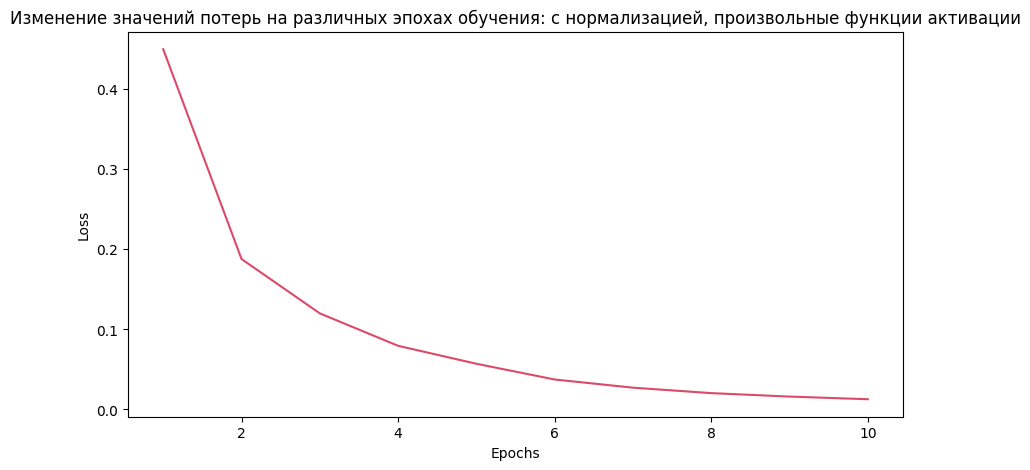

In [30]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#DD4968")
plt.title("Изменение значений потерь на различных эпохах обучения: с нормализацией, произвольные функции активации")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Как изменилась `accuracy` после нормализации?

Нормализация положительно повлияла на `accuracy`: показатель увеличился с 0.8967 до 0.9039.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

Epoch=1 loss=1.8696
Epoch=2 loss=1.6351
Epoch=3 loss=1.5799
Epoch=4 loss=1.5511
Epoch=5 loss=1.5329
Epoch=6 loss=1.5192
Epoch=7 loss=1.5085
Epoch=8 loss=1.5004
Epoch=9 loss=1.4945
Epoch=10 loss=1.4895
С функцией активации Sigmoid accuracy=0.8785.
Epoch=1 loss=0.4499
Epoch=2 loss=0.1745
Epoch=3 loss=0.1099
Epoch=4 loss=0.0728
Epoch=5 loss=0.0490
Epoch=6 loss=0.0338
Epoch=7 loss=0.0245
Epoch=8 loss=0.0177
Epoch=9 loss=0.0167
Epoch=10 loss=0.0211
С функцией активации GELU accuracy=0.9027.
Epoch=1 loss=1.1264
Epoch=2 loss=0.9329
Epoch=3 loss=0.8841
Epoch=4 loss=0.8593
Epoch=5 loss=0.8441
Epoch=6 loss=0.8334
Epoch=7 loss=0.8264
Epoch=8 loss=0.8227
Epoch=9 loss=0.8179
Epoch=10 loss=0.8162
С функцией активации Tanh accuracy=0.8967.


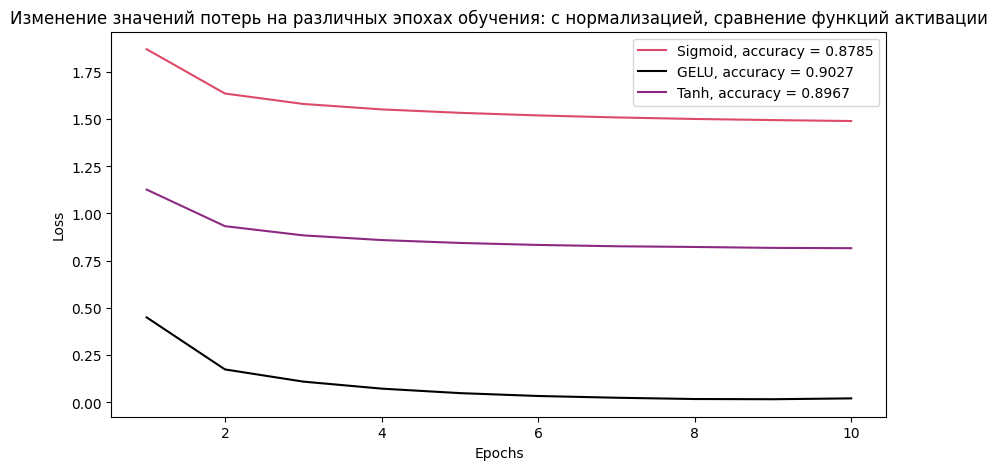

In [31]:
## YOUR CODE HERE
n_epochs = 10
lr = 0.001

loss_history = []
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return torch.sigmoid(x)

        #return logits

fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f"С функцией активации Sigmoid accuracy={acc}.")

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#DD4968", label=f"Sigmoid, accuracy = {acc}")
plt.title("Изменение значений потерь на различных эпохах обучения: с нормализацией, сравнение функций активации")
plt.xlabel("Epochs")
plt.ylabel("Loss")

loss_history = []
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = nn.GELU()(x)
        x = self.fc2(x)
        x = nn.GELU()(x)
        x = self.fc3(x)
        
        return nn.GELU()(x)

        #return logits
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f"С функцией активации GELU accuracy={acc}.")

plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#000003", label=f"GELU, accuracy = {acc}")

loss_history = []
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = nn.Tanh()(x)
        x = self.fc2(x)
        x = nn.Tanh()(x)
        x = self.fc3(x)
        
        return nn.Tanh()(x)

        #return logits
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f"С функцией активации Tanh accuracy={acc}.")

plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#8C2980", label=f"Tanh, accuracy = {acc}")
plt.legend()
plt.show()

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

В данном случае наибольшей `accuracy` удалось досчить с помощью GELU, если использовать только её. Был также ряд запусков, в которых уверенно лидировал Tanh, но стабильно не воспроизводится. В основном GELU.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

Epoch=1 loss=0.4496
Epoch=2 loss=0.1737
Epoch=3 loss=0.1109
Epoch=4 loss=0.0754
Epoch=5 loss=0.0492
Epoch=6 loss=0.0322
Epoch=7 loss=0.0231
Epoch=8 loss=0.0205
Epoch=9 loss=0.0228
Epoch=10 loss=0.0196
С оптимизатором Adam accuracy=0.9013.
Epoch=1 loss=0.3682
Epoch=2 loss=0.1445
Epoch=3 loss=0.0925
Epoch=4 loss=0.0616
Epoch=5 loss=0.0420
Epoch=6 loss=0.0302
Epoch=7 loss=0.0244
Epoch=8 loss=0.0212
Epoch=9 loss=0.0162
Epoch=10 loss=0.0153
С оптимизатором RMSprop accuracy=0.9028.
Epoch=1 loss=0.7122
Epoch=2 loss=0.4501
Epoch=3 loss=0.3925
Epoch=4 loss=0.3593
Epoch=5 loss=0.3362
Epoch=6 loss=0.3177
Epoch=7 loss=0.3035
Epoch=8 loss=0.2914
Epoch=9 loss=0.2813
Epoch=10 loss=0.2722
С оптимизатором Adagrad accuracy=0.8143.


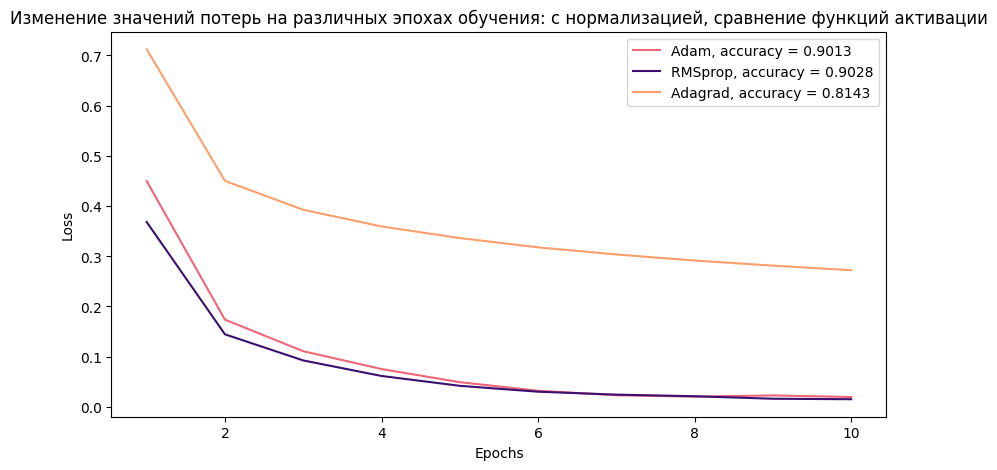

In [32]:
# Наибольшей accuracy удалось досчить с помощью GELU, поэтому возвращаем её

loss_history = []

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = nn.GELU()(x)
        x = self.fc2(x)
        x = nn.GELU()(x)
        x = self.fc3(x)
        
        return nn.GELU()(x)

        #return logits
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f'С оптимизатором Adam accuracy={acc}.')

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#EE6677", label=f"Adam, accuracy = {acc}")
plt.title("Изменение значений потерь на различных эпохах обучения: с нормализацией, сравнение функций активации")
plt.xlabel("Epochs")
plt.ylabel("Loss")

loss_history = []
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f'С оптимизатором RMSprop accuracy={acc}.')

plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#3B0F6F", label=f"RMSprop, accuracy = {acc}")

loss_history = []
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f'С оптимизатором Adagrad accuracy={acc}.')

plt.plot([i+1 for i in range(n_epochs)], loss_history, c="#FD9F6C", label=f"Adagrad, accuracy = {acc}")
plt.legend()
plt.show()

В итоге наибольшей `accuracy` удалось досчить с помощью функции активации GELU и оптимизатора RMSprop. Adam держался близко и иногда выходил вперёд, Adagrad всегда в конце.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилось.

In [58]:
loss_history = []
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        
        return nn.ReLU()(x)

        #return logits
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f"С функцией активации RELU accuracy={acc}.")

Epoch=1 loss=0.5418
Epoch=2 loss=0.1873
Epoch=3 loss=0.1200
Epoch=4 loss=0.0812
Epoch=5 loss=0.0568
Epoch=6 loss=0.0396
Epoch=7 loss=0.0283
Epoch=8 loss=0.0244
Epoch=9 loss=0.0177
Epoch=10 loss=0.0149
С функцией активации RELU accuracy=0.9022.


In [59]:
ReLU_predictions = []
for i in range(10):
    image, label = trainset[i]
    ReLU_predictions.append(torch.argmax(fc_net(image)))

In [60]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        x = x.clip(min=0)

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [61]:
loss_history = []
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = CustomReLU()(x)
        x = self.fc2(x)
        x = CustomReLU()(x)
        x = self.fc3(x)
        
        return CustomReLU()(x)

        #return logits
        
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
fc_fit(n_epochs)
acc = get_accuracy(fc_net, testloader)
print(f"С функцией активации CustomReLU accuracy={acc}.")

Epoch=1 loss=0.4952
Epoch=2 loss=0.1874
Epoch=3 loss=0.1221
Epoch=4 loss=0.0837
Epoch=5 loss=0.0583
Epoch=6 loss=0.0434
Epoch=7 loss=0.0312
Epoch=8 loss=0.0239
Epoch=9 loss=0.0186
Epoch=10 loss=0.0181
С функцией активации CustomReLU accuracy=0.8968.


In [62]:
CustomReLU_predictions = []
for i in range(10):
    image, label = trainset[i]
    CustomReLU_predictions.append(torch.argmax(fc_net(image)))

In [63]:
# Это параноидальная проверка

print(ReLU_predictions)
print(CustomReLU_predictions)
print(all([i == j for i, j in zip(ReLU_predictions, CustomReLU_predictions)]))

[tensor(8), tensor(7), tensor(0), tensor(1), tensor(4), tensor(2), tensor(4), tensor(8), tensor(1), tensor(1)]
[tensor(8), tensor(7), tensor(0), tensor(1), tensor(4), tensor(2), tensor(4), tensor(8), tensor(1), tensor(1)]
True


In [64]:
# Это непараноидальная проверка (чтобы запустить, когда уже видел, что предсказания получились одинаковые :) )

assert all([i == j for i, j in zip(ReLU_predictions, CustomReLU_predictions)])

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Линейная регрессия учится на датасете в стиле экспрессионизм:
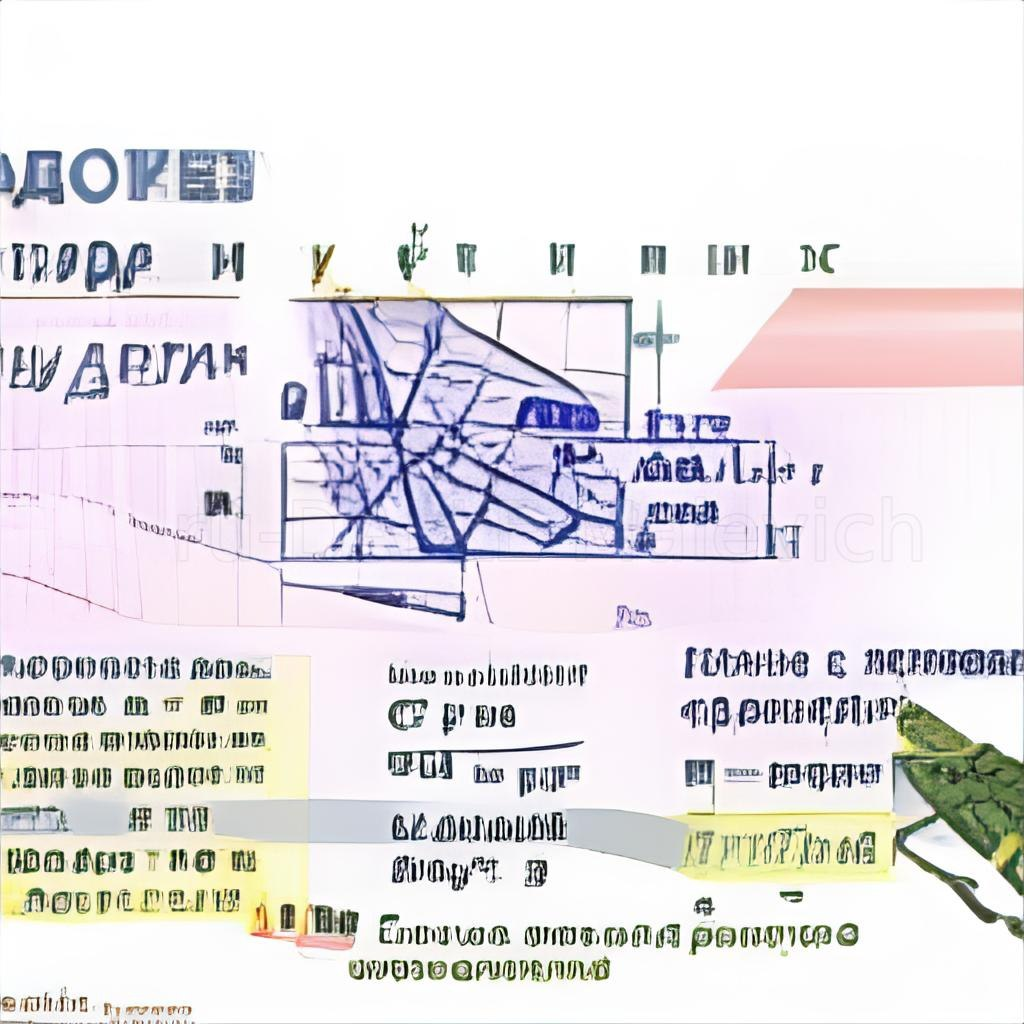

Средневековая фреска, изображающая Данилу-Мастера и студента машинного обучения:
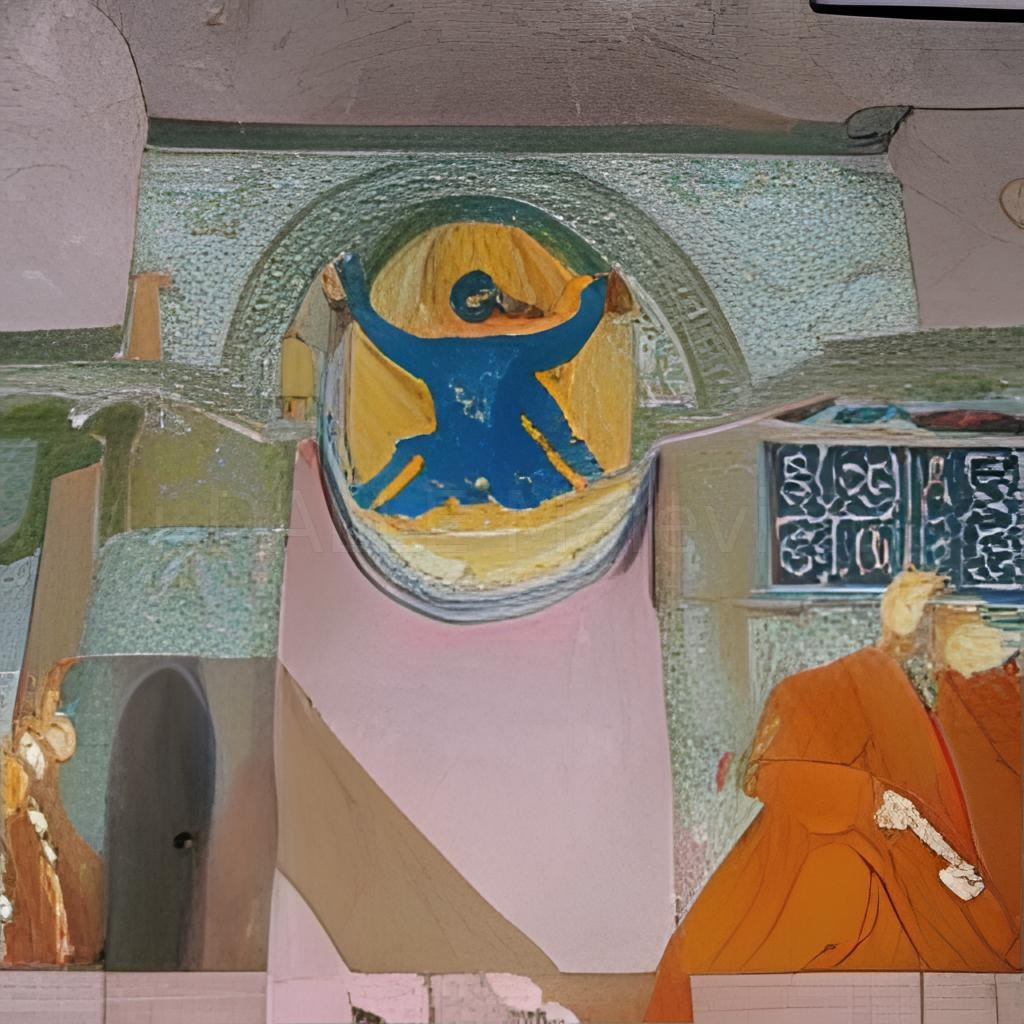

Модель машинного обучения в карандашной графике:
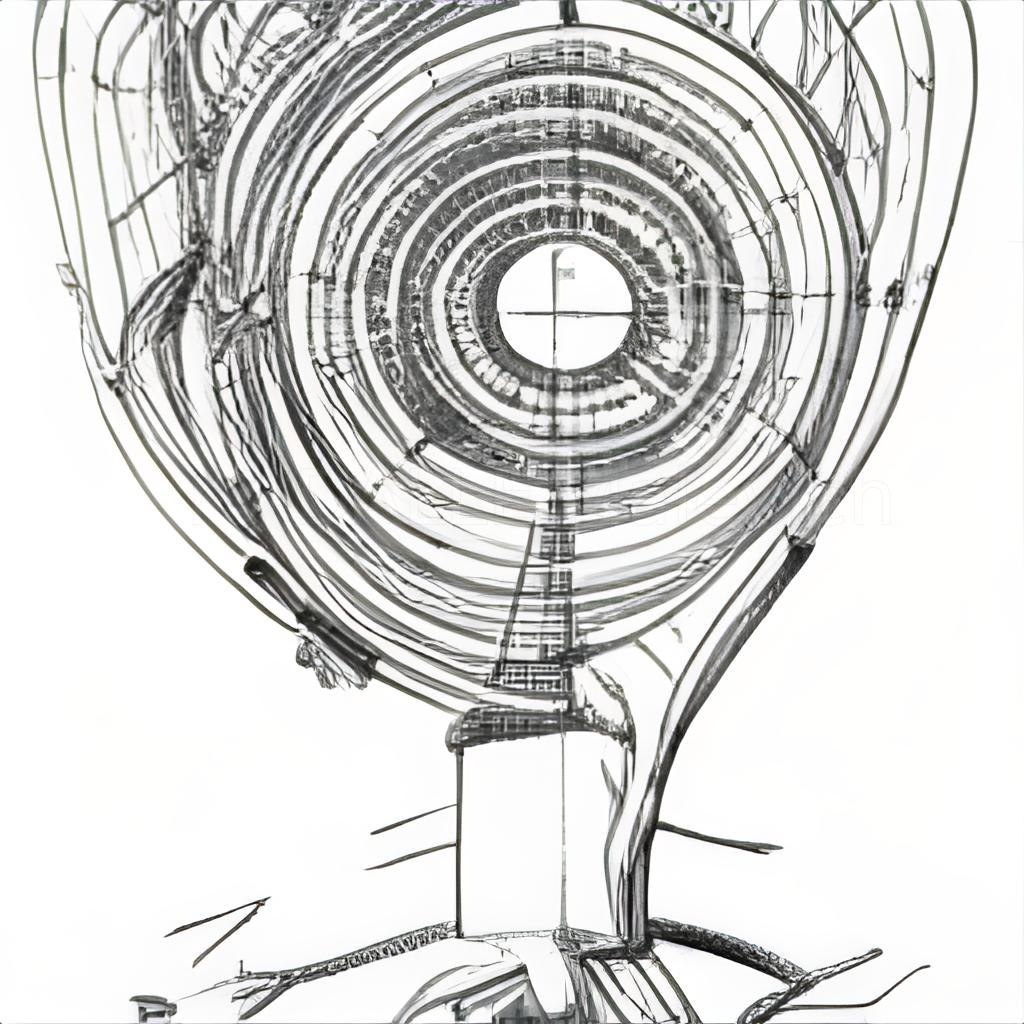

Бонус: мультяшное изображение кота, укравшего все сосиски:
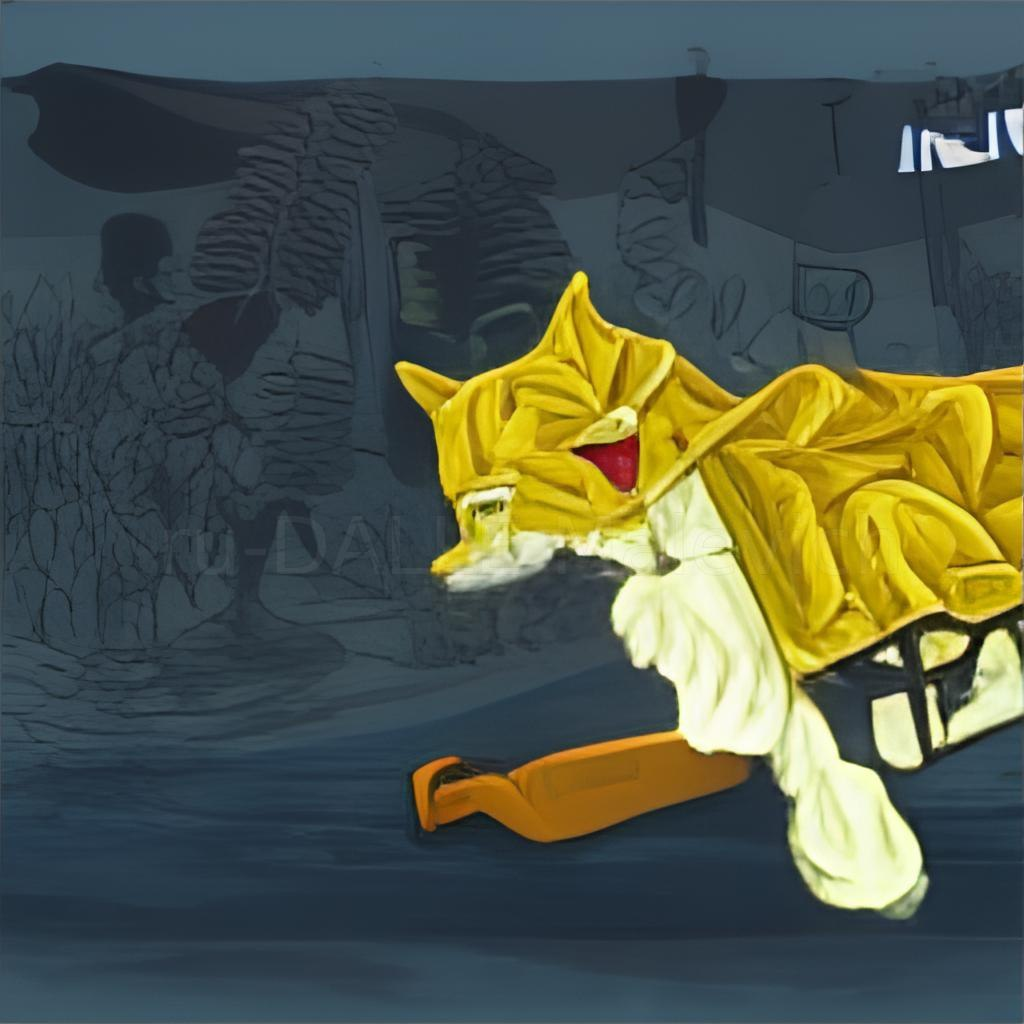